In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import platform
#import SIRD_Model_Experimental
import SIRD_Model
from sklearn import linear_model


# Determining Beta At Time t

# $\beta_{t} = \sigma_{t} \cdot \frac{q \cdot Pop + \tilde I_{C(t)} - \tilde Z_{t}}{\tilde I_{C(t)} (q \cdot Pop - \tilde Z_{t})} \cdot \tilde Z_{t} $ 

# All Current Files Start at March 7

In [2]:
def getGamma(infect, dead):
    
    recovG = approxRecovered(infect, dead)
    infect = infect - recovG - dead
    infect = infect[:-1].reshape((len(infect[:-1]),1))
    recovGD = np.diff(recovG)
    recovGD - recovGD.reshape((len(recovGD),1))

    gamma = np.linalg.lstsq(infect, recovGD, rcond = None)[0][0]
    return gamma

def getPop(state):
    path="../Data/"
    csvfile=open(path+"2020 Population Data.csv", newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[3:])
    for i in range(len(aData)):
        if state in aData[i][0]:
            pop = float(aData[i][1]) * 1000000
    return pop

def getPopC(county,state):
    path="../Data/"
    csvfile=open(path+"PopulationEstimates.csv", newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[3:])
    for i in range(len(aData)):
        if state in aData[i][1] and county in aData[i][2]:
            temp = aData[i][19]
            pop = float(temp.replace(',',''))
    return pop

def getNu(infect, dead):
    
    recovG = approxRecovered(infect, dead)
    infect = infect - recovG - dead #current infected
    infect = infect[:-1].reshape((len(infect[:-1]),1))
    deadD = np.diff(dead)
    deadD - deadD.reshape((len(deadD),1))

    nu = np.linalg.lstsq(infect, deadD, rcond = None)[0][0]
    return nu

def approxRecovered(infect, dead):
    recovG = np.zeros(len(infect))
    for i in range(len(infect) - 13):
        recovG[i + 13] = infect[i] - dead[i + 13]
    return recovG


def getBeta(pop, q, infect, dead, winSize):
    

    sigma = regressionSlopeSeries(infect, winSize )
    recov = approxRecovered(infect, dead)
    infectN = infect - recov - dead
    Z = infect 
    Zt = Z 
    It = infectN 
    halfwin = winSize // 2
    Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
    
    #fig,ax = plt.subplots(figsize = (18,8))
    #ax.plot(sigma, '.', color = 'red')
    #ax.set_title("Sigma (Estimated Derivative) Over Time")
    
    return Beta
    
    
def getRegressionSlope(points):
    """
    Takes a given number of points and outputs slope determined by linear regression
    Times can be included, if they are not, the indexes are assumed to be the times, starting from 0
    """
    timeArray = np.ones((len(points), 2))
    timeArray[:,1]  = np.arange(len(points))
    pointArray = np.array(points)
    point_slope, res, _, _ = np.linalg.lstsq(timeArray, pointArray, rcond=None)
    slope = point_slope[1]
    return res, slope

def regressionSlopeSeries(points, window):
    """
    Given a series of points and a window size, estimates the slope at each point
    Outputs both the estimated slopes and regression errors for all applicable points
    If times list is provided, each of the included times should match up respectively with the points
    Window should be odd, if it isn't it will automatically be interpreted as one larger than the argument passed
    """
    # cut the window in half so we know how long it extends on both sides
    half_window = window//2
    num_points = len(points)
    slopes = []

    for i in range(num_points):
        # if there are not enough previous values to satisfy window size, continue
        if i < half_window:
            continue
        # if there are not enough values after the current one to satisfy window size, break
        if num_points-i <= half_window:
            break
        res, slope = getRegressionSlope(points[i-half_window: i+half_window])
        slopes.append(slope)

    slopes = np.array(slopes)
    return slopes

def getOandC(filename, smallerCategories = False):

    if(smallerCategories):
        bO = []
        sO = []
        bC = []
        sC = []
        csvfile=open(filename, newline='', encoding='UTF-8')
        rd = csv.reader(csvfile, delimiter=',')
        data=[]
        for lv in rd: #generating the data matrix
            data.append(lv)
        aData=(data[1:])
       
        for i in range(len(aData)):
            if("Major Closure" in aData[i][1]):
                bC.append(aData[i][0])
            if("Minor Closure" in aData[i][1]):
                sC.append(aData[i][0])
            if("Minor Opening" in aData[i][1]):
                sO.append(aData[i][0])
            if("Major Opening" in aData[i][1]):
                bO.append(aData[i][0])

        return bO,sO,bC,sC
    else:
        O = []
        C = []

        csvfile=open(filename, newline='', encoding='UTF-8')
        rd = csv.reader(csvfile, delimiter=',')
        data=[]
        for lv in rd: #generating the data matrix
            data.append(lv)
        aData=(data[1:])
        for i in range(len(aData)):
            if("Closure" in aData[i][1]):
                C.append(aData[i][0])
            if("Opening" in aData[i][1]):
                O.append(aData[i][0])
        return O,C

def displayOandC(filename, beta, ax, dates,window, smallerCategories = False):
    #Add or modify dates for closures or openings here

    if(smallerCategories):
        bOpening,sOpening, bClosure, sClosure = getOandC(filename, smallerCategories)

        bOind = []
        sOind = []
        bCind = []
        sCind = []

        hWin = window // 2
        temp = dates.tolist()
        #Get the indexes for each opening or closing date
        for i in range(len(bOpening)):
            bOind.append(temp.index(bOpening[i]))
        for i in range(len(sOpening)):
            sOind.append(temp.index(sOpening[i]))
        for i in range(len(bClosure)):
            bCind.append(temp.index(bClosure[i]))
        for i in range(len(sClosure)):
            sCind.append(temp.index(sClosure[i]))

        #Variables used to fix legend duplications
        temp1 = 0
        temp3 = 0
        temp2 = 0
        temp4 = 0
        #Add the dashed lines going up to the beta curve

        for i in range(len(bOind)): 
            if(temp1 == 0):
                plt.vlines(x = bOind[i] + hWin,color ='red',ymin = 0,linestyle = 'dashed', ymax = beta[bOind[i]], label = "Major Openings")
                temp1 = 1
            else:
                plt.vlines(x = bOind[i] + hWin,color ='red',ymin = 0,linestyle = 'dashed', ymax = beta[bOind[i]] )
        for i in range(len(sOind)): 
            if(temp3 == 0):
                plt.vlines(x = sOind[i] + hWin,color ='orange',ymin = 0,linestyle = 'dashed', ymax = beta[sOind[i]], label = "Minor Openings")
                temp3 = 1
            else:
                plt.vlines(x = sOind[i] + hWin,color ='orange',ymin = 0,linestyle = 'dashed', ymax = beta[sOind[i]] )
        for i in range(len(bCind)):
            if(temp2 == 0):
                plt.vlines(x = bCind[i] + hWin,color ='green',ymin = 0,linestyle = 'dashed', ymax = beta[bCind[i]], label = "Major Closures")
                temp2 = 1
            else:
                plt.vlines(x = bCind[i] + hWin,color ='green',ymin = 0,linestyle = 'dashed', ymax = beta[bCind[i]])
        for i in range(len(sCind)):
            if(temp4 == 0):
                plt.vlines(x = sCind[i] + hWin,color ='cyan',ymin = 0,linestyle = 'dashed', ymax = beta[sCind[i]], label = "Minor Closures")
                temp4 = 1
            else:
                plt.vlines(x = sCind[i] + hWin,color ='cyan',ymin = 0,linestyle = 'dashed', ymax = beta[sCind[i]])
        ax.legend(fontsize=20)
    else:
        Opening, Closure = getOandC(filename, smallerCategories)

        Oind = []
        Cind = []

        hWin = window // 2
        temp = dates.tolist()
        #Get the indexes for each opening or closing date
        for i in range(len(Opening)):
            Oind.append(temp.index(Opening[i]))
        for i in range(len(Closure)):
            Cind.append(temp.index(Closure[i]))


        #Variables used to fix legend duplications
        temp1 = 0
        temp2 = 0

        #Add the dashed lines going up to the beta curve
        for i in range(len(Oind)): 
            if(temp1 == 0):
                plt.vlines(x = Oind[i] + hWin,color ='red',ymin = 0,linestyle = 'dashed', ymax = beta[Oind[i]], label = "Openings")
                temp1 = 1
            else:
                plt.vlines(x = Oind[i] + hWin,color ='red',ymin = 0,linestyle = 'dashed', ymax = beta[Oind[i]] )
        for i in range(len(Cind)):
            if(temp2 == 0):
                plt.vlines(x = Cind[i] + hWin,color ='green',ymin = 0,linestyle = 'dashed', ymax = beta[Cind[i]], label = "Closures")
                temp2 = 1
            else:
                plt.vlines(x = Cind[i] + hWin,color ='green',ymin = 0,linestyle = 'dashed', ymax = beta[Cind[i]])
        ax.legend(fontsize=20)
        
def displayMeasures(filename, measures, beta, ax, dates, window, colors = ('red', 'orange', 'yellow', 'green', 'teal', 'blue', 'purple', 'cyan', 'navy', 'crimson'), chop_year=False):
    #Add or modify dates for closures or openings here

    measure_dates = {}
    
    for measure in measures:
        measure_dates[measure] = getMandate(filename, dates, measure, exact=True)

    measure_inds = {measure: [] for measure in measures}

    hWin = window // 2
    temp = dates.tolist()
    #Get the indexes for each opening or closing date
    for measure in measures:
        for i in range(len(measure_dates[measure])):
            # if data file is representing years by only their last two digets, adjust dates appropriately
            if chop_year:
                date = measure_dates[measure][i]
                date = date[:-4]+date[-2:]
                measure_inds[measure].append(temp.index(date))
            else:
                measure_inds[measure].append(temp.index(measure_dates[measure][i]))

    #List used to fix legend duplications
    dupe = []
    closure = 0
    #we choose 10 days since it emperically fits the data the best
    closure_offset = 10

    #Add the dashed lines going up to the beta curve
    for measure in measures:
        for i in range(len(measure_inds[measure])):
            ymax = .17#beta[measure_inds[measure][i]]
            if ("Lifted" not in measure and "Opened" not in measure) or ("Disallowed" in measure) or ("Clos" in measure):
                closure = 1
            else:
                closure = 0
            if not measure in dupe:
                dupe.append(measure)
                plt.vlines(x=measure_inds[measure][i]+hWin-(closure_offset*closure), color=colors[dupe.index(measure)%len(colors)], ymin=0, linestyle='dashed', ymax=ymax, label=measure, linewidth=3)
            else:
                plt.vlines(x=measure_inds[measure][i]+hWin-(closure_offset*closure), color=colors[dupe.index(measure)%len(colors)], ymin=0, linestyle='dashed', ymax=ymax, linewidth=3)
    ax.legend(fontsize=20)
    
#predict the next some days using constant parameters
def calculateFuture(infect, recov, dead, pop, daysToPredict, params, q):
    
    #A=sirdmatrix, and dt=nextIterMatrix, if we know S(t) we should be able to predict S(t+1)
    suscept = q*pop - infect - recov - dead
    dt, A = SIRD_Model.getSIRDMatrices(suscept, infect, recov, dead)

    sirdPredict = np.zeros((len(A) + daysToPredict, 4, 3))
    dtPredict = np.zeros((len(dt) + daysToPredict, 4, 1))

    sirdPredict[0:len(A)] = A
    dtPredict[0:len(dt)] = dt

    susceptPredict = np.zeros(len(suscept) + daysToPredict)
    infectPredict = np.zeros(len(infect) + daysToPredict)
    recovPredict = np.zeros(len(recov) + daysToPredict)
    deadPredict = np.zeros(len(dead) + daysToPredict)

    susceptPredict[0:len(suscept)] = suscept
    infectPredict[0:len(infect)] = infect
    recovPredict[0:len(recov)] = recov
    deadPredict[0:len(dead)] = dead

    T = len(suscept)
    for t in range(T-1, T + daysToPredict - 1): #go from last element in known list to end of prediction, see paper for method
        #populate the 4x3 matrix with parameters
        sirdPredict[t,0,0] = -(susceptPredict[t] * infectPredict[t]) / (susceptPredict[t] + infectPredict[t])
        sirdPredict[t,1,0] = (susceptPredict[t] * infectPredict[t]) / (susceptPredict[t] + infectPredict[t])
        sirdPredict[t,1,1] = -infectPredict[t]
        sirdPredict[t,1,2] = -infectPredict[t]
        sirdPredict[t,2,1] = infectPredict[t]
        sirdPredict[t,3,2] = infectPredict[t]

        #find next dtPredict
        dtPredict[t,:,0] = (sirdPredict[t] @ params)

        #find next SIRD, based on dtPredict[t] (which is S(t+1) - S(t)) to predict S(t) (and so on)
        susceptPredict[t+1] = susceptPredict[t] + dtPredict[t,0,0]
        infectPredict[t+1] = infectPredict[t] + dtPredict[t,1,0]
        recovPredict[t+1] = recovPredict[t] + dtPredict[t,2,0]
        deadPredict[t+1] = deadPredict[t] + dtPredict[t,3,0]
    
    return susceptPredict, infectPredict, recovPredict, deadPredict, q, params


#predict future days that are not known
def predictFuture(infect, recov, dead, pop, daysToPredict, param, qVal, graphVals=[True,True,True,True]):
    pS, pI, pR, pD, q, params = calculateFuture(infect, recov, dead, pop, daysToPredict, param, qVal)
    
    suscept = q*pop - infect - recov - dead
    
    #plot actual and predicted values
    fig, ax = plt.subplots(figsize=(18,8))
    if(graphVals[0]):
        ax.plot(suscept, color='blue', label='suscpetible')
        ax.plot(pS, color='blue', label='suscpetible', linestyle='dashed')
    if(graphVals[1]):
        ax.plot(infect, color='orange', label='infected')
        ax.plot(pI, color='orange', label='infected', linestyle='dashed')
    if(graphVals[2]):
        ax.plot(recov, color='green', label='recovered')
        ax.plot(pR, color='green', label='recovered', linestyle='dashed')
    if(graphVals[3]):
        ax.plot(dead, color='black', label='dead')
        ax.plot(pD, color='black', label='dead', linestyle='dashed')

    
#predict days that are known for testing purposes, predicts the end portion of the given data
def predictMatch(infect, recov, dead, pop, daysToPredict, param, qVal, graphVals=[True,True,True,True]):
    pS, pI, pR, pD, q, params = calculateFuture(infect[0:-daysToPredict], recov[0:-daysToPredict], dead[0:-daysToPredict], pop, daysToPredict, param, qVal)
    
    suscept = q*pop - infect - recov - dead
    
    #plot actual and predicted values
    fig, ax = plt.subplots(figsize=(18,8))

    if(graphVals[0]):
        ax.plot(suscept, color='blue', label='suscpetible')
        ax.plot(pS, color='blue', label='suscpetible', linestyle='dashed')
    if(graphVals[1]):
        ax.plot(infect, color='orange', label='infected')
        ax.plot(pI, color='orange', label='infected', linestyle='dashed')
    if(graphVals[2]):
        ax.plot(recov, color='green', label='recovered')
        ax.plot(pR, color='green', label='recovered', linestyle='dashed')
    if(graphVals[3]):
        ax.plot(dead, color='black', label='dead')
        ax.plot(pD, color='black', label='dead', linestyle='dashed')
        
def getDeathDiff(O,C,dates,simDate,beta,infect,dead,pop,q,numDays):
    ocList = []
    oInd = 0
    cInd = 0

    temp = dates.tolist()
    recov = approxRecovered(infect, dead)
    while(oInd < len(O) and cInd < len(C)):
        if(temp.index(O[oInd]) < temp.index(C[cInd])):
            ocList.append(O[oInd])
            oInd = oInd + 1
        else:
            ocList.append(C[cInd])
            cInd = cInd + 1
    while(oInd < len(O)):
        ocList.append(O[oInd])
        oInd = oInd + 1
    while(cInd < len(C)):
        ocList.append(C[cInd])
        cInd = cInd + 1

    print("Open markers: ", O)
    print("Close markers: ", C)
    print()

    simLastEl = temp.index(simDate) + 21 >= len(temp)
    if(simLastEl):
        endDate = dates[(len(beta))]
    else:
        endDate = dates[temp.index(simDate)+21]
    startDate = dates[temp.index(simDate)-14]
    #catch markers on edge
    if(temp.index(startDate) >= temp.index(simDate)):
        startDate = dates[0]

    
   

    temp = dates.tolist()
    startInd = temp.index(startDate)
    simInd = temp.index(simDate)
    endInd = temp.index(endDate)


    print("Start, Mid, End: ", startDate, simDate, endDate)
    #print(startInd, simInd, endInd)
    simBetaAfter = np.average(beta[simInd+7:endInd])
    simBetaBefore = np.average(beta[startInd:simInd])
    print("beta before: ", simBetaBefore)
    print("beta after: ", simBetaAfter)

    betaPDiff = (simBetaAfter - simBetaBefore) / simBetaBefore * 100
    print("Percentage Change in Beta:", betaPDiff, "%")
    
    recov = approxRecovered(infect, dead)
    currInfect = infect - dead - recov
    paramA = [simBetaAfter, getGamma(infect, dead), getNu(infect, dead)]
    paramB = [simBetaBefore, getGamma(infect, dead), getNu(infect, dead)]
    infectT = currInfect[:endInd]
    recovT = recov[:endInd]
    deadT = dead[:endInd]
   
    daysToPredict = (endInd - simInd)
    
    pS, pI, pR, pDB, q, paramB = calculateFuture(infectT[0:-daysToPredict], recovT[0:-daysToPredict], deadT[0:-daysToPredict], pop, daysToPredict, paramB, q)

    #plot actual and predicted values
    
    pS, pI, pR, pDA, q, paramA = calculateFuture(infectT[0:-daysToPredict], recovT[0:-daysToPredict], deadT[0:-daysToPredict], pop, daysToPredict, paramA, q)
    print("Difference in Probable Deaths After Policy Change:", -pDB[-1] + pDA[-1])
    print(paramA)

    fig, ax = plt.subplots(figsize=(18,8))
    ax.plot(pDB[startInd:], color='red', label='Previous Probable Deaths', linestyle = 'dashed')
    ax.plot(pDA[startInd:], color='blue', label='After Probable Deaths', linestyle='dashed')
    ax.plot(deadT[startInd:], color='black', label='Reported Deaths')
    
    
    ax.legend(fontsize=20)
    
def betaWithKernel(beta): #Apply a convolution kernel to the data
    x = np.arange(-7, 8)
    kernel2 = np.exp(-(x) ** 2 / (2 * 7 ** 2))#The middle term on the right is the sigma value
    kernel2=kernel2/sum(kernel2)
    newBeta = np.convolve(beta, kernel2, 'same')
    return newBeta

# Parsing Mandate Data

In [3]:
def getMandate(filename,dates,mandate,closure=True,exact=False):
    if closure:
        nixwords = ('Lifted', 'Open')
    else:
        nixwords = ('Closed', 'Restricted')
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    M = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if exact:
            if mandate == aData[i][1]:
                M.append(aData[i][0])
        else:
            if(mandate in aData[i][1]):
                # check if any words which do not belong are in the name
                should_append = True
                for word in nixwords:
                    if (word in aData[i][1]):
                        should_append = False
                if should_append:
                    M.append(aData[i][0])
    return M

convert = {
    'AL':'Alabama',
    'AK':'Alaska',
    'AS':'American Samoa' ,
    'AZ':'Arizona' ,
    'AR':'Arkansas',
    'CA':'California',
    'CO':'Colorado',
    'CT':'Connecticut',
    'DE':'Delaware',
    'DC':'District of Columbia',
    'FL':'Florida',
    'GA':'Georgia',
    'GU':'Guam',
    'HI':'Hawaii',
    'ID':'Idaho',
    'IL':'Illinois',
    'IN':'Indiana',
    'IA':'Iowa',
    'KS':'Kansas',
    'KY':'Kentucky',
    'LA':'Louisiana',
    'ME':'Maine',
    'MD':'Maryland',
    'MA':'Massachusetts',
    'MI':'Michigan',
    'MN':'Minnesota',
    'MS':'Mississippi',
    'MO':'Missouri',
    'MT':'Montana',
    'NE':'Nebraska',
    'NV':'Nevada',
    'NH':'New Hampshire',
    'NJ':'New Jersey',
    'NM':'New Mexico',
    'NY':'New York',
    'NC':'North Carolina',
    'ND':'North Dakota',
    'MP':'Northern Mariana Island',
    'OH':'Ohio',
    'OK':'Oklahoma',
    'OR':'Oregon',
    'PA':'Pennsylvania',
    'PR':'Puerto Rico',
    'RI':'Rhode Island',
    'SC':'South Carolina',
    'SD':'South Dakota',
    'TN':'Tennessee',
    'TX':'Texas',
    'UT':'Utah',
    'VT':'Vermont',
    'VA':'Virginia',
    'VI':'Virgin Islands',
    'WA':'Washington',
    'WV':'West Virginia',
    'WI':'Wisconsin',
    'WY':'Wyoming'
}

convert.update(dict(reversed(item) for item in convert.items()))

# Graph Generating Code

<ipython-input-2-acd573e1324b>:69: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-2-acd573e1324b>:69: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-2-acd573e1324b>:69: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-2-acd573e1324b>:69: RuntimeWarning: invalid value encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwi

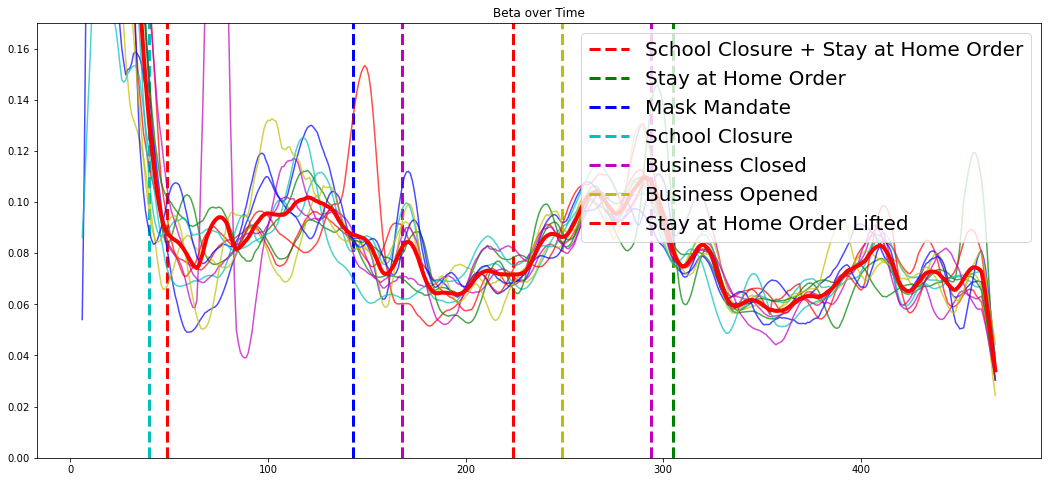

In [4]:
def getGraph(infection_file, mandate_file, region, mandates, mandate_colors = 'rgbcmy', chop_year=False, save=False, save_path='../Paper Stuff/', form='png'):
    
    dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(infection_file)

    #Change population based on the state you want to use
    if region not in convert.keys():
        state = convert[region.split()[1]]
        region = region.split()[0]
        pop = int(getPopC(region, state))
    else:
        pop = int(getPop(region))
    numDays = len(infectRaw)
    infect = infectRaw[0:numDays]
    dead = deadRaw[0:numDays]

    gamma = getGamma(infect,dead)
    nu = getNu(infect,dead)
    q = 1 #0.0754
    window = 13
    hWin = window // 2
    # use a kernel to smooth beta
    beta = betaWithKernel(getBeta(pop, q, infect, dead, window))
    #print(gamma, beta)

    x = np.arange(hWin,len(beta)+hWin) 

    fig, ax = plt.subplots(figsize = (18,8))
    ax.plot(x,beta)
    ax.set_title("Beta over Time")
    #plt.yscale("log")
    print(dates[0],dates[-1])
    midInd = len(dates)//2
    temp = dates.tolist()

    displayMeasures(mandate_file, mandates, beta, ax, dates, window, mandate_colors, chop_year)
    if save:
        fig.savefig('{}{}_Figure.{}'.format(save_path, region, form))
    
def addRelativeGraph(infection_file, region, threshold=10, fig=None, ax=None, color=None):
    """
    infection_file: file for infection data
    region: state or county name used to label the graph
    threshold: infected people per 1,000 needed in order to start calculating beta
    """
    dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(infection_file)

    #Change population based on the state you want to use
    if region not in convert.keys():
        state = convert[region.split()[-1]]
        region_list = region.split()[:-1]
        region = '';
        for r in region_list[:-1]:
            region += r+' ';
        region += region_list[-1]
        pop = int(getPopC(region, state))
    else:
        pop = int(getPop(region))
        
    numDays = len(infectRaw)
    thresholdInd = numDays
    for i in range(len(infectRaw)):
        if infectRaw[i]/pop >= 0.001*threshold:
            thresholdInd = i
            break
    if thresholdInd < 30:
        thresholdInd = 30
            
    infect = infectRaw[thresholdInd:numDays]
    dead = deadRaw[thresholdInd:numDays]

    gamma = getGamma(infect,dead)
    nu = getNu(infect,dead)
    q = 1 #0.0754
    window = 13
    hWin = window // 2
    # use a kernel to smooth beta
    beta = betaWithKernel(getBeta(pop, q, infect, dead, window))
    #print(gamma, beta)

    x = np.arange(hWin,len(beta)+hWin) 

    if (fig is None or ax is None):
        fig, ax = plt.subplots(figsize = (18,8))
    if color is not None:
        ax.plot(x,beta,color=color, label=region)
    else:
        ax.plot(x, beta, label=region)
    ax.set_title("Beta over Time")
    #plt.yscale("log")
    midInd = len(dates)//2
    temp = dates.tolist()
    #ax.legend(fontsize=20)
    return fig, ax
        
def addGraph(infection_file, region, fig=None, ax=None, color=None, alpha=1, displayMandates=False, graph_i = 0, running_mean = None):
    """
    infection_file: file for infection data
    region: state or county name used to label the graph
    threshold: infected people per 1,000 needed in order to start calculating beta
    """
    dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(infection_file)

    #Change population based on the state you want to use
    if region not in convert.keys():
        state = convert[region.split()[-1]]
        region_list = region.split()[:-1]
        region = '';
        for r in region_list[:-1]:
            region += r+' ';
        region += region_list[-1]
        pop = int(getPopC(region, state))
    else:
        pop = int(getPop(region))
        
    numDays = len(infectRaw)
            
    infect = infectRaw[30:numDays]
    dead = deadRaw[30:numDays]
    
    gamma = getGamma(infect,dead)
    nu = getNu(infect,dead)
    q = 1 #0.0754
    window = 13
    hWin = window // 2
    # use a kernel to smooth beta
    beta = betaWithKernel(getBeta(pop, q, infect, dead, window))
    #print(gamma, beta)
    
    graph_i += 1
    if running_mean is None:
        running_mean = beta
    else:
        running_mean[:numDays] = ((running_mean[:numDays])*(graph_i-1)+beta[:numDays])/graph_i

    x = np.arange(hWin,len(beta)+hWin) 

    if (fig is None or ax is None):
        fig, ax = plt.subplots(figsize = (18,8))
        ax.set_ylim([0, 0.17])
    if color is not None:
        ax.plot(x, beta, color=color, alpha=alpha)#, label=region)
    else:
        ax.plot(x, beta, alpha=alpha)#, label=region)
    ax.set_title("Beta over Time")
    #plt.yscale("log")
    midInd = len(dates)//2
    temp = dates.tolist()
    #ax.legend(fontsize=20)
    if displayMandates:
        mandate_file = '../Data/State Closure Data/California Mandate Data.csv'
        mandates = ['School Closure + Stay at Home Order', 'Stay at Home Order', 'Mask Mandate', 'School Closure', 'Business Closed', 'Business Opened', 'Stay at Home Order Lifted']
        displayMeasures(mandate_file, mandates, beta, ax, dates, window, 'rgbcmy', chop_year=True)
    return fig, ax, graph_i, running_mean

def getStateGraph(state, mandates, mandate_colors = 'rgbcmy', save=False, save_path='../Paper Stuff/', form='png'):
    data_path = "../Data/Covid Tracking State Data/"
    mandate_path = "../Data/State Closure Data/"
    infection_file = '{}{}.csv'.format(data_path, convert[state])
    mandate_file = '{}{} State Data.csv'.format(mandate_path, state)
    getGraph(infection_file, mandate_file, state, mandates, mandate_colors)
    
def getCountyGraph(county, state, mandates, mandate_colors = 'rgbcmy', save=False, save_path='../Paper Stuff/', form='png'):
    data_path = "../Data/JHU Data/County Data/"
    mandate_path = "../Data/State Closure Data/County Closure Data/"
    filename = '{} County, {}.csv'.format(county, convert[state])
    infection_file = data_path+filename
    mandate_file = mandate_path+filename
    getGraph(infection_file, mandate_file, county+' '+state, mandates, mandate_colors, chop_year=True)

county_path = "../Data/JHU Data/County Data/"
#getGraph('CA.csv', 'California Mandate Data.csv', 'California', ['Mask Mandate', 'Stay at Home Order'])
#getCountyGraph("Alameda", "California", ["Mask Mandate", "Stay at Home Order"])
colors = 'rgbcmy'
state = 'California'
"""
Alameda
Contra Costa
Santa Barbra # need to generate data for this one
Sacremento
Los Angeles
San Francisco #
"""
counties = ['Alameda', 'Los Angeles', 'Sacramento', 'Contra Costa', 'Santa Barbara', 'San Mateo', 'Kern', 'Fresno', 'Monterey', 'Orange', 'Riverside', 'San Joaquin']
"""
fig, ax = addRelativeGraph(county_path+"{} County, {}.csv".format(counties[0], convert[state]), "{} {}".format(counties[0], state), 10, color='r')
for i in range(1,len(counties)):
    addRelativeGraph(county_path+'{} County, {}.csv'.format(counties[i], convert[state]), "{} {}".format(counties[i], state), 10, fig, ax, colors[i%len(colors)])
"""
fig, ax, graph_i, running_mean = addGraph(county_path+"{} County, {}.csv".format(counties[0], convert[state]), "{} {}".format(counties[0], state), color='r', alpha=.7)
for i in range(1,len(counties)):
    graphMandates = i==len(counties)-1
    fig, ax, graph_i, running_mean = addGraph(county_path+'{} County, {}.csv'.format(counties[i], convert[state]), "{} {}".format(counties[i], state), fig, ax, colors[i%len(colors)], .7, graphMandates, graph_i, running_mean)

window = 13
hWin = window // 2
x = np.arange(hWin,len(running_mean)+hWin) 
ax.plot(x, running_mean, color='red', linewidth=4)

mandate_file = '../Data/State Closure Data/California Mandate Data.csv'
mandates = ['Stay at Home Order', 'Mask Mandate']